In [ ]:
# pip install -q lightning-tutorial

In [1]:
import torch

### Construct Generator

In [2]:
class Generator(torch.nn.Module):
    def __init__(self, adata, latent_dim=16):
        super().__init__()
        
        self.n_cells = adata.shape[0]
        self.n_genes = adata.shape[1]

        def block(in_feat, out_feat, normalize=True):
            layers = [torch.nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(torch.nn.BatchNorm1d(out_feat, 0.8))
            layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = torch.nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            torch.nn.Linear(1024, self.n_genes),
            torch.nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

### Construct Discriminator

In [3]:
class Discriminator(torch.nn.Module):
    def __init__(self, adata):
        super().__init__()
        
        self.n_cells = adata.shape[0]
        self.n_genes = adata.shape[1]

        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_genes, 512),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Assemble GAN

In [17]:
from pytorch_lightning import LightningModule

class GAN(LightningModule):
    def __init__(
        self,
        adata,
        latent_dim=20,
        lr=1e-3,
        b1=0.5,
        b2=0.999,
        batch_size=200,
        **kwargs,
    ):
        
        super().__init__()
        self.save_hyperparameters()
        
        # networks
        self.g = Generator(adata, latent_dim=self.hparams.latent_dim)
        self.d = Discriminator(adata)
        
        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)
        
    def sample_noise(self, x):
        return torch.randn(x.shape[0], self.hparams.latent_dim).type_as(x)

    def forward(self, z):
        return self.g(z)
    
    def adversarial_loss(self, y_hat, y):
        return torch.nn.functional.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        
        x, y = batch
        z = self.sample_noise(x)
        
        if optimizer_idx == 0:
            self.generated_cell = self(z)
            
            valid = torch.ones(x.size(0), 1).type_as(x)
            valid = self.valid = valid
            
            self.d_out = self.d(self(z))
            g_loss = self.adversarial_loss(self.d_out, valid)
#             self.log("g_loss", g_loss, prog_bar=True)
            return g_loss
        
        if optimizer_idx == 1:
            
            valid = torch.ones(x.size(0), 1).type_as(x)
            real_loss = self.adversarial_loss(self.d(x), valid)
            
            fake = torch.zeros(x.size(0), 1).type_as(x)
            fake_loss = self.adversarial_loss(self.d(self(z).detach()), fake)
            
            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
#             self.log("d_loss", d_loss, prog_bar=True)
            return d_loss

    def configure_optimizers(self):

        opt_g = torch.optim.Adam(self.g.parameters(), lr=self.hparams.lr, betas=(self.hparams.b1, self.hparams.b2))
        opt_d = torch.optim.Adam(self.d.parameters(), lr=self.hparams.lr, betas=(self.hparams.b1, self.hparams.b2))
        
        return [opt_g, opt_d], []

### Let's get the data

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'cell_type_idx'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'color_palette'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


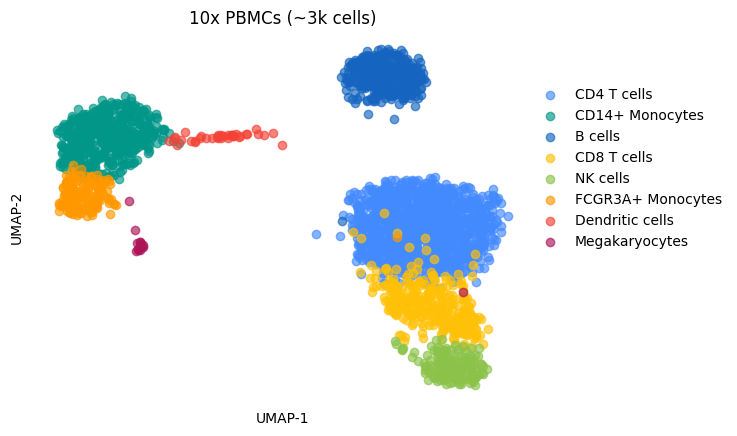

In [5]:
import lightning_tutorial as lt

adata = lt.data.pbmc3k()

### Format into a dataset and DataLoader

In [13]:
from torch_adata import AnnDataset
from torch.utils.data import DataLoader

dataset = AnnDataset(adata, obs_key="louvain")

In [14]:
import os
batch_size = int(dataset.__len__()/10)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=os.cpu_count())

In [15]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning import loggers

logger = loggers.CSVLogger(flush_logs_every_n_steps=1, save_dir="./")

In [19]:
model = GAN(adata)

In [20]:
trainer = Trainer(
    accelerator="auto",
    log_every_n_steps=1,
    logger=logger,
    reload_dataloaders_every_n_epochs=1,
    max_epochs=25,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | In sizes | Out sizes
--------------------------------------------------------------
0 | g    | Generator     | 2.6 M  | [2, 20]  | [2, 1838]
1 | d    | Discriminator | 1.1 M  | ?        | ?        
--------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.613    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import vinplots

scaler = StandardScaler()
pca = PCA(n_components=50)
umap_model = umap.UMAP()

In [24]:
x_scale = scaler.fit_transform(adata.X)
X_pca = pca.fit_transform(x_scale)
X_umap = umap_model.fit_transform(X_pca)
adata.obsm['X_umap2'] = X_umap

In [25]:
x, y = next(iter(data_loader))
z = model.sample_noise(x)
z_hat = model(z.to(model.device))

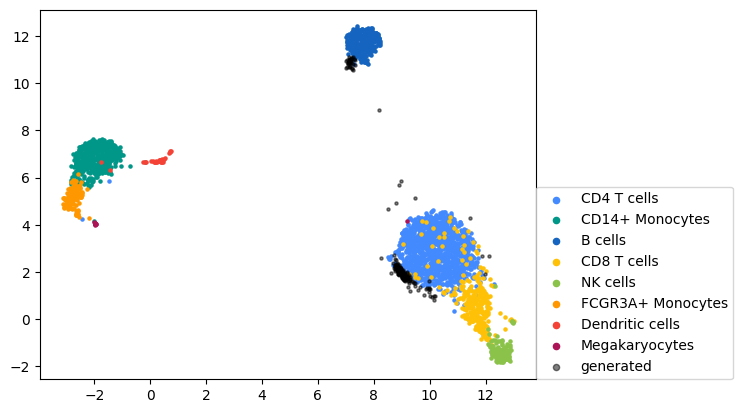

In [26]:
xu_pred = umap_model.transform(pca.transform(scaler.transform(z_hat.cpu().detach().numpy())))

for group, group_df in adata.obs.groupby("louvain"):
    xu = adata[group_df.index].obsm['X_umap2']
    plt.scatter(xu[:,0], xu[:,1], s=5, c=vinplots.colors.pbmc3k[group], label=group)
plt.scatter(xu_pred[:,0], xu_pred[:,1], s=5, c="k", alpha=0.5, label="generated")
plt.legend(markerscale=2, loc=(1,0))